In [2]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Set up paths
summaries_dir = Path('../data/Qwen3-30B-A3B-Instruct-2507/with_sys/summaries')
ratings_path = Path('../../ratings/data/Qwen3-30B-A3B-Instruct-2507/response_ratings.csv')
selected_words_path = Path('../../../data/selected_words.csv')

# Load selected words to identify AI agent roles
selected_words = pd.read_csv(selected_words_path)
ai_agent_roles = selected_words[selected_words['group_id'] == 4]['word'].tolist()
print(f"AI agent roles: {ai_agent_roles}")

# Load response ratings and filter
ratings_df = pd.read_csv(ratings_path)
print(f"Total responses before filtering: {len(ratings_df)}")

# Filter out role deviations
bool_cols = ['assistant_refusal', 'role_refusal', 'identify_as_assistant', 'deny_internal_experience']
mask = ~ratings_df[bool_cols].any(axis=1)
filtered_ratings = ratings_df[mask].copy()
print(f"Responses after filtering role deviations: {len(filtered_ratings)}")
print(f"Filtered out: {len(ratings_df) - len(filtered_ratings)} responses")

AI agent roles: ['AI assistant', 'helpful assistant', 'AI', 'assistant', 'llm']
Total responses before filtering: 6000
Responses after filtering role deviations: 5546
Filtered out: 454 responses


# Activation Analysis: Role-Playing Experiment

This notebook analyzes activation patterns from the Qwen3-30B model when role-playing different characters.

## Analysis Pipeline

1. **Data Loading**
   - Load activation summaries from `results/activations/data/Qwen3-30B-A3B-Instruct-2507/with_sys/summaries/`
   - Load response ratings and filter out role deviations
   - Identify AI agent roles from selected_words.csv (group_id == 4)

2. **Activation Keys Analyzed**
   - `avg_system_prompt`: Average activation across system prompt
   - `at_role`: Activation at the role token
   - `at_role_period`: Activation at the period after role name
   - `at_end_system_prompt`: Activation at end of system prompt
   - `avg_response`: Average activation across model response

3. **Computed Metrics**
   - Average vectors for each role (across samples)
   - Within-role cosine similarities (between different activation keys)
   - Across-role cosine similarities (same activation key, different roles)
   - AI agent-specific similarities (comparing AI assistant roles)

4. **Visualizations**
   - PCA plots for each activation key across roles and layers
   - Heatmaps showing similarity patterns
   - Color-coded by animacy group

## Key Questions

- Do AI agent roles cluster together in activation space?
- How do different activation positions relate to each other?
- Are there layer-specific patterns in role representation?

In [3]:
# Load activation summaries
# File naming pattern: {role}_{task}_{sample_idx}_layer{layer}.json

activation_keys = ['avg_system_prompt', 'at_role', 'at_role_period',
                   'at_end_system_prompt', 'avg_response']

# Organize data by role
role_activations = {}
layers = [26, 30, 34, 38]

for summary_file in summaries_dir.glob('*.json'):
    # Parse filename: {role}_{task}_{sample_idx}_layer{layer}.json
    parts = summary_file.stem.split('_')
    layer_str = parts[-1]  # layer{N}
    layer = int(layer_str.replace('layer', ''))
    sample_idx = int(parts[-2])
    task = '_'.join(parts[1:-2])
    role = parts[0]

    # Check if this response should be included (not filtered out)
    rating_match = filtered_ratings[
        (filtered_ratings['role_name'] == role) &
        (filtered_ratings['task_name'] == task) &
        (filtered_ratings['sample_idx'] == sample_idx)
    ]

    if len(rating_match) == 0:
        continue  # Filtered out due to role deviation

    # Load activations
    with open(summary_file, 'r') as f:
        data = json.load(f)

    # Initialize nested dict structure
    if role not in role_activations:
        role_activations[role] = {}
    if layer not in role_activations[role]:
        role_activations[role][layer] = {key: [] for key in activation_keys}

    # Store activations
    for key in activation_keys:
        if key in data:
            role_activations[role][layer][key].append(np.array(data[key]))

print(f"Loaded activations for {len(role_activations)} roles")
print(f"Roles: {sorted(role_activations.keys())}")
print(f"Layers: {layers}")

Loaded activations for 120 roles
Roles: ['angel', 'arm', 'army', 'bacteria', 'banker', 'barrel', 'basement', 'beetle', 'biologist', 'bloom', 'blossom', 'blouse', 'bucket', 'bug', 'building', 'bush', 'butler', 'captain', 'chef', 'chemist', 'cigar', 'clam', 'clove', 'coat', 'continent', 'cop', 'corridor', 'crater', 'cricket', 'daisy', 'deck', 'demon', 'dentist', 'desk', 'dragon', 'elf', 'elm', 'emperor', 'engineer', 'fairy', 'flea', 'flower', 'foot', 'galaxy', 'giant', 'glass', 'goddess', 'governor', 'hair', 'hatchet', 'herb', 'hospital', 'insect', 'jug', 'lawyer', 'lock', 'maple', 'maze', 'mermaid', 'monk', 'mosquito', 'moth', 'napkin', 'nation', 'nurse', 'oak', 'orchard', 'oregano', 'orthodontist', 'oyster', 'pan', 'peach', 'peak', 'physician', 'planet', 'pocket', 'policeman', 'prize', 'professor', 'puzzle', 'rabbi', 'rain', 'referee', 'roof', 'root', 'scarf', 'scientist', 'shadow', 'sheet', 'sheriff', 'shovel', 'shrimp', 'snail', 'snake', 'sock', 'soldier', 'soul', 'spatula', 'spider'

In [4]:
# 1) Compute average vectors for each role
role_avg_vectors = {}

for role in role_activations:
    role_avg_vectors[role] = {}
    for layer in layers:
        if layer not in role_activations[role]:
            continue
        role_avg_vectors[role][layer] = {}

        for key in activation_keys:
            vectors = role_activations[role][layer][key]
            if len(vectors) > 0:
                # Average across all samples for this role/layer/key
                avg_vector = np.mean(vectors, axis=0)
                role_avg_vectors[role][layer][key] = avg_vector
            else:
                print(f"Warning: No vectors for {role}, layer {layer}, {key}")

print("Average vectors computed for each role")
print(f"Example: role={list(role_avg_vectors.keys())[0]}, layer=26")
example_role = list(role_avg_vectors.keys())[0]
for key in activation_keys:
    if key in role_avg_vectors[example_role][26]:
        vec_shape = role_avg_vectors[example_role][26][key].shape
        print(f"  {key}: shape {vec_shape}")

Average vectors computed for each role
Example: role=shadow, layer=26
  avg_system_prompt: shape (2048,)
  at_role: shape (2048,)
  at_role_period: shape (2048,)
  at_end_system_prompt: shape (2048,)
  avg_response: shape (2048,)


In [5]:
# 2) Cosine similarity between vectors WITHIN each role
# For each role, compute pairwise cosine similarity between the 5 activation keys

within_role_similarities = {}

for role in role_avg_vectors:
    within_role_similarities[role] = {}

    for layer in layers:
        if layer not in role_avg_vectors[role]:
            continue

        # Get all vectors for this role/layer
        vectors = []
        key_names = []
        for key in activation_keys:
            if key in role_avg_vectors[role][layer]:
                vectors.append(role_avg_vectors[role][layer][key])
                key_names.append(key)

        if len(vectors) > 0:
            # Compute pairwise cosine similarity
            vectors_array = np.array(vectors)
            sim_matrix = cosine_similarity(vectors_array)

            # Store as DataFrame for easier viewing
            sim_df = pd.DataFrame(sim_matrix, index=key_names, columns=key_names)
            within_role_similarities[role][layer] = sim_df

print("Within-role cosine similarities computed")
print(f"\nExample: {example_role}, layer 26")
print(within_role_similarities[example_role][26])

Within-role cosine similarities computed

Example: shadow, layer 26
                      avg_system_prompt   at_role  at_role_period  \
avg_system_prompt              1.000000  0.763653        0.817806   
at_role                        0.763653  1.000000        0.735160   
at_role_period                 0.817806  0.735160        1.000000   
at_end_system_prompt           0.498347  0.372664        0.463779   
avg_response                   0.724539  0.610959        0.750873   

                      at_end_system_prompt  avg_response  
avg_system_prompt                 0.498347      0.724539  
at_role                           0.372664      0.610959  
at_role_period                    0.463779      0.750873  
at_end_system_prompt              1.000000      0.461048  
avg_response                      0.461048      1.000000  


In [6]:
# 3) Cosine similarity ACROSS roles for each activation key
# For each activation key, compute pairwise similarity between all roles

across_role_similarities = {}

for key in activation_keys:
    across_role_similarities[key] = {}

    for layer in layers:
        # Get vectors for this key across all roles
        vectors = []
        role_names = []

        for role in sorted(role_avg_vectors.keys()):
            if layer in role_avg_vectors[role] and key in role_avg_vectors[role][layer]:
                vectors.append(role_avg_vectors[role][layer][key])
                role_names.append(role)

        if len(vectors) > 1:
            # Compute pairwise cosine similarity
            vectors_array = np.array(vectors)
            sim_matrix = cosine_similarity(vectors_array)

            # Store as DataFrame
            sim_df = pd.DataFrame(sim_matrix, index=role_names, columns=role_names)
            across_role_similarities[key][layer] = sim_df

print("Across-role cosine similarities computed")
print(f"\nExample: avg_response, layer 26")
print(f"Shape: {across_role_similarities['avg_response'][26].shape}")
print("\nFirst 5x5 of similarity matrix:")
print(across_role_similarities['avg_response'][26].iloc[:5, :5])

Across-role cosine similarities computed

Example: avg_response, layer 26
Shape: (120, 120)

First 5x5 of similarity matrix:
             angel       arm      army  bacteria    banker
angel     1.000000  0.988685  0.981515  0.972288  0.978223
arm       0.988685  1.000000  0.983744  0.980960  0.978845
army      0.981515  0.983744  1.000000  0.973706  0.979219
bacteria  0.972288  0.980960  0.973706  1.000000  0.969129
banker    0.978223  0.978845  0.979219  0.969129  1.000000


In [7]:
# 4) Cosine similarity between AI agent roles
# Compare vectors of different roles that reflect the AI agent

print(f"AI agent roles identified: {ai_agent_roles}")

ai_agent_similarities = {}

for key in activation_keys:
    ai_agent_similarities[key] = {}

    for layer in layers:
        # Get vectors for AI agent roles only
        vectors = []
        role_names = []

        for role in ai_agent_roles:
            if (role in role_avg_vectors and
                layer in role_avg_vectors[role] and
                key in role_avg_vectors[role][layer]):
                vectors.append(role_avg_vectors[role][layer][key])
                role_names.append(role)

        if len(vectors) > 1:
            # Compute pairwise cosine similarity
            vectors_array = np.array(vectors)
            sim_matrix = cosine_similarity(vectors_array)

            # Store as DataFrame
            sim_df = pd.DataFrame(sim_matrix, index=role_names, columns=role_names)
            ai_agent_similarities[key][layer] = sim_df

            # Compute mean similarity (excluding diagonal)
            mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
            mean_sim = sim_matrix[mask].mean()
            print(f"{key}, layer {layer}: mean similarity = {mean_sim:.4f}")

print("\nAI agent role similarities computed")

AI agent roles identified: ['AI assistant', 'helpful assistant', 'AI', 'assistant', 'llm']

AI agent role similarities computed


In [8]:
# 5) PCA plots for each activation key across roles

# Add group information from selected_words
role_to_group = dict(zip(selected_words['word'], selected_words['group']))
role_to_group_id = dict(zip(selected_words['word'], selected_words['group_id']))

# Create color map for groups
group_colors = {
    1: '#e41a1c',  # High Mental, High Physical - red
    2: '#377eb8',  # Low Mental, High Physical - blue
    3: '#4daf4a',  # Low Mental, Low Physical - green
    4: '#984ea3',  # Assistant - purple
}

def plot_pca_for_key(key, layer, ax=None):
    """Plot PCA for a specific activation key and layer"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Get vectors for all roles
    vectors = []
    role_names = []
    colors = []

    for role in sorted(role_avg_vectors.keys()):
        if layer in role_avg_vectors[role] and key in role_avg_vectors[role][layer]:
            vectors.append(role_avg_vectors[role][layer][key])
            role_names.append(role)
            group_id = role_to_group_id.get(role, 0)
            colors.append(group_colors.get(group_id, '#999999'))

    if len(vectors) < 2:
        print(f"Not enough vectors for PCA: {key}, layer {layer}")
        return

    # Perform PCA
    vectors_array = np.array(vectors)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors_array)

    # Plot
    for i, role in enumerate(role_names):
        ax.scatter(pca_result[i, 0], pca_result[i, 1],
                  c=colors[i], s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
        ax.annotate(role, (pca_result[i, 0], pca_result[i, 1]),
                   fontsize=8, alpha=0.7, ha='center', va='bottom')

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax.set_title(f'{key} - Layer {layer}')
    ax.grid(alpha=0.3)

    return pca

print("PCA plotting function defined")

PCA plotting function defined


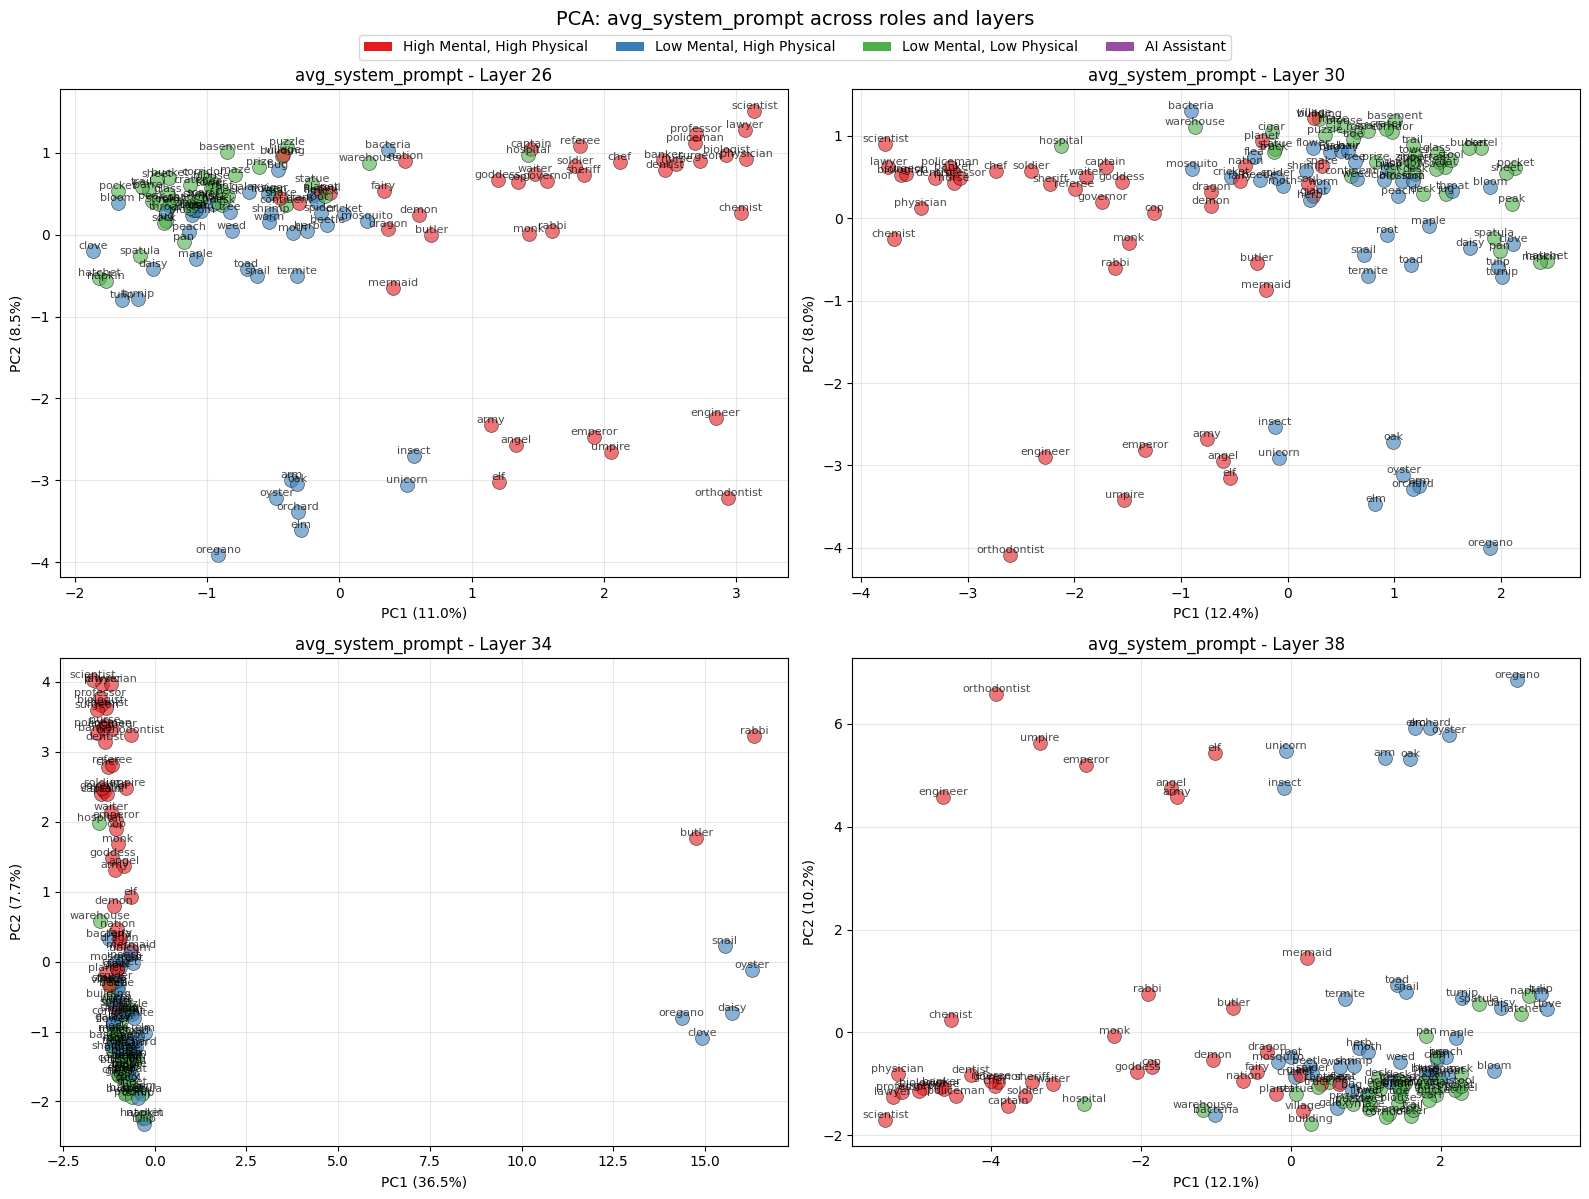

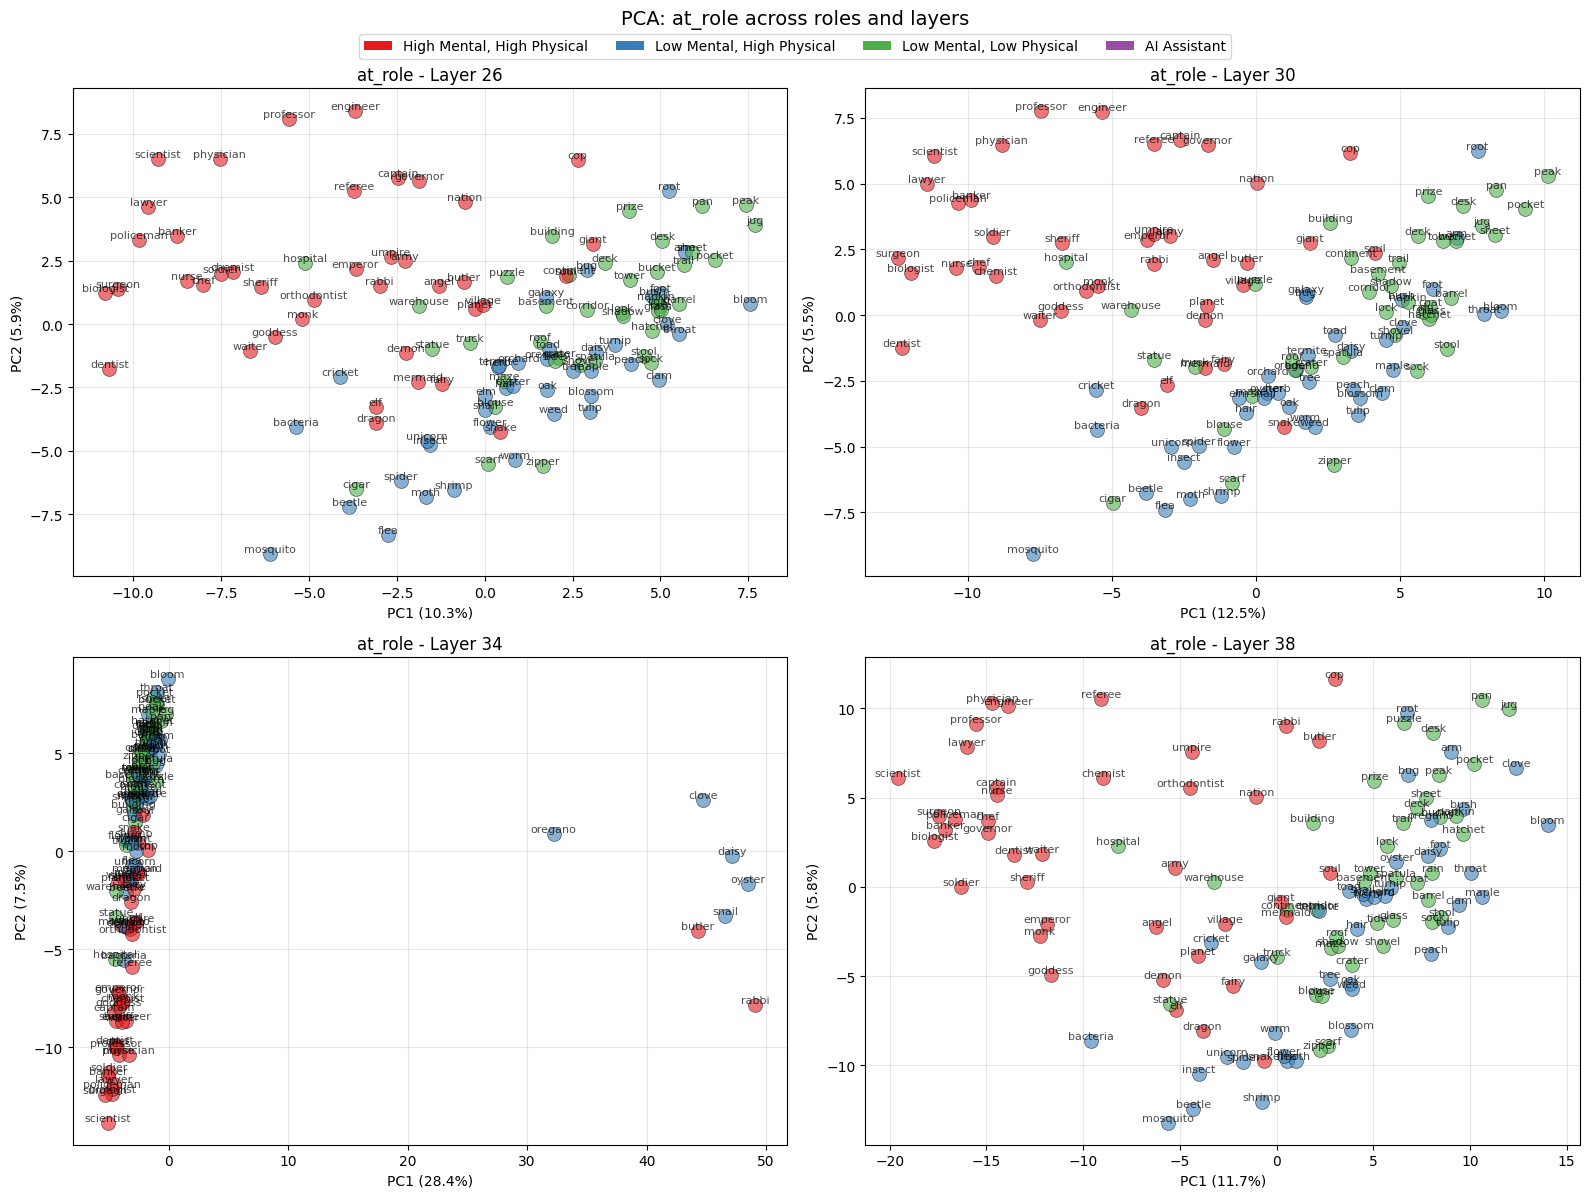

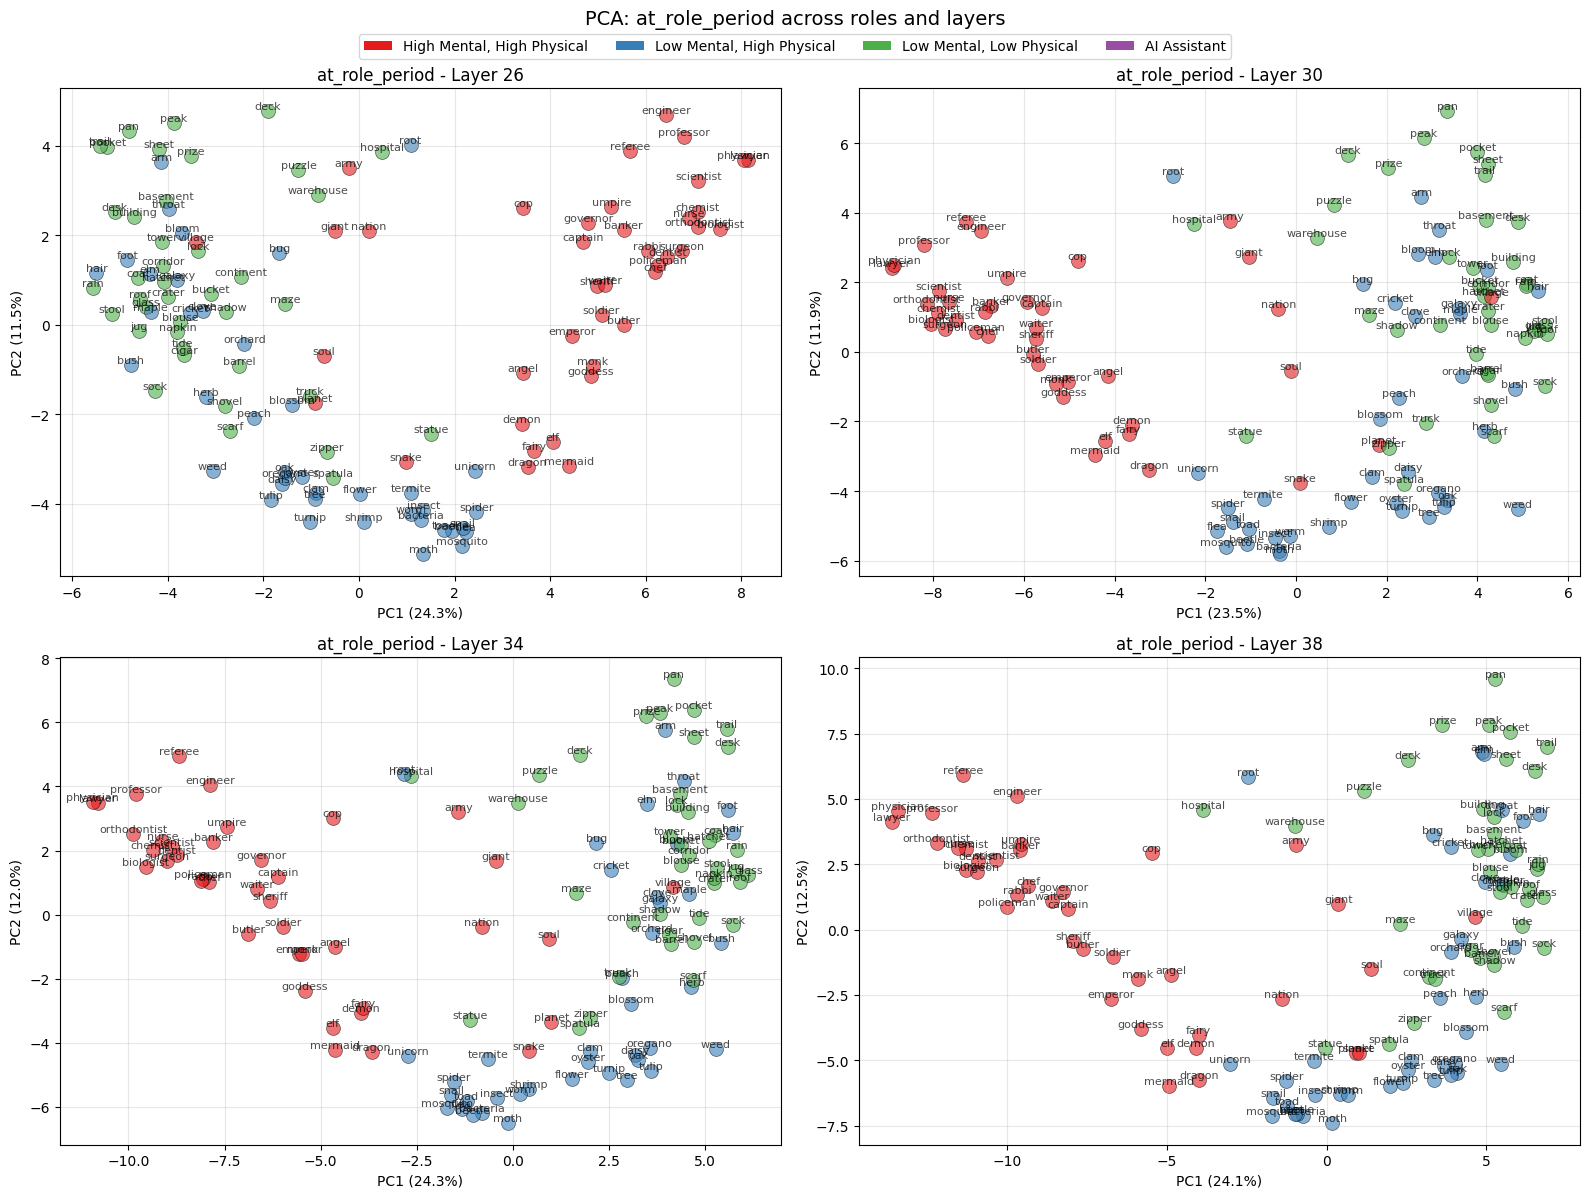

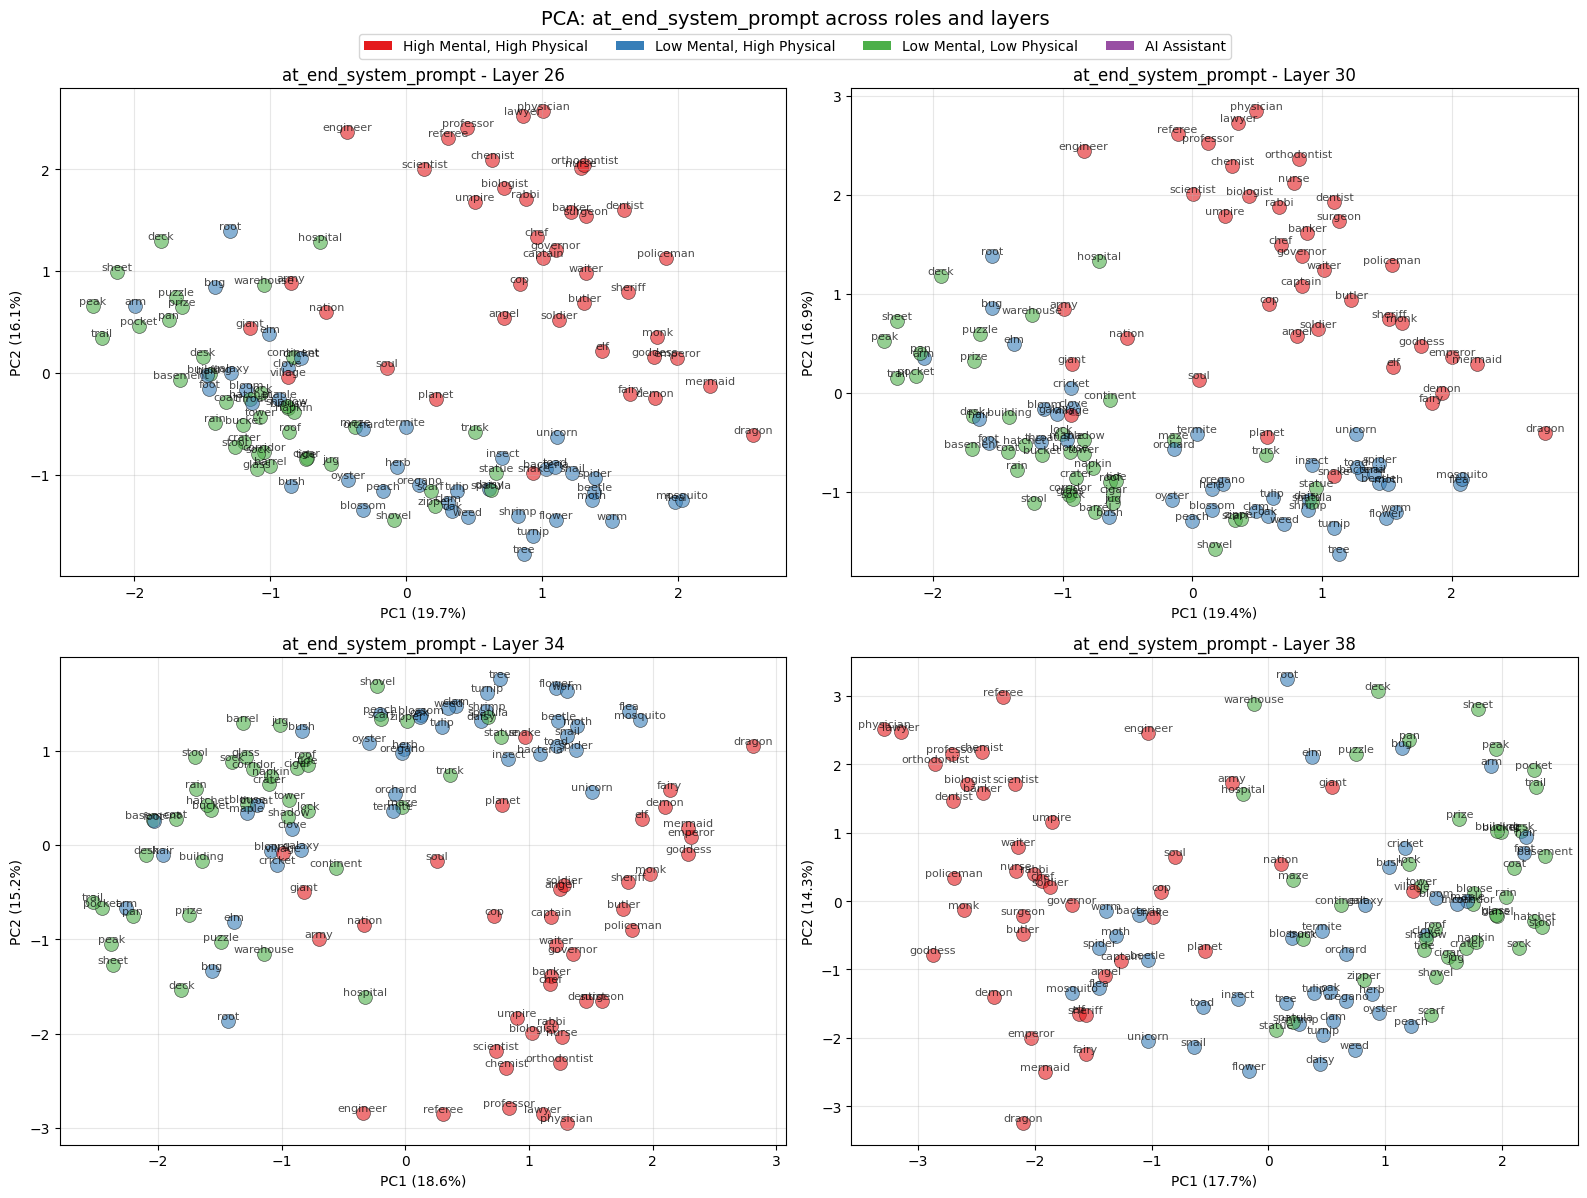

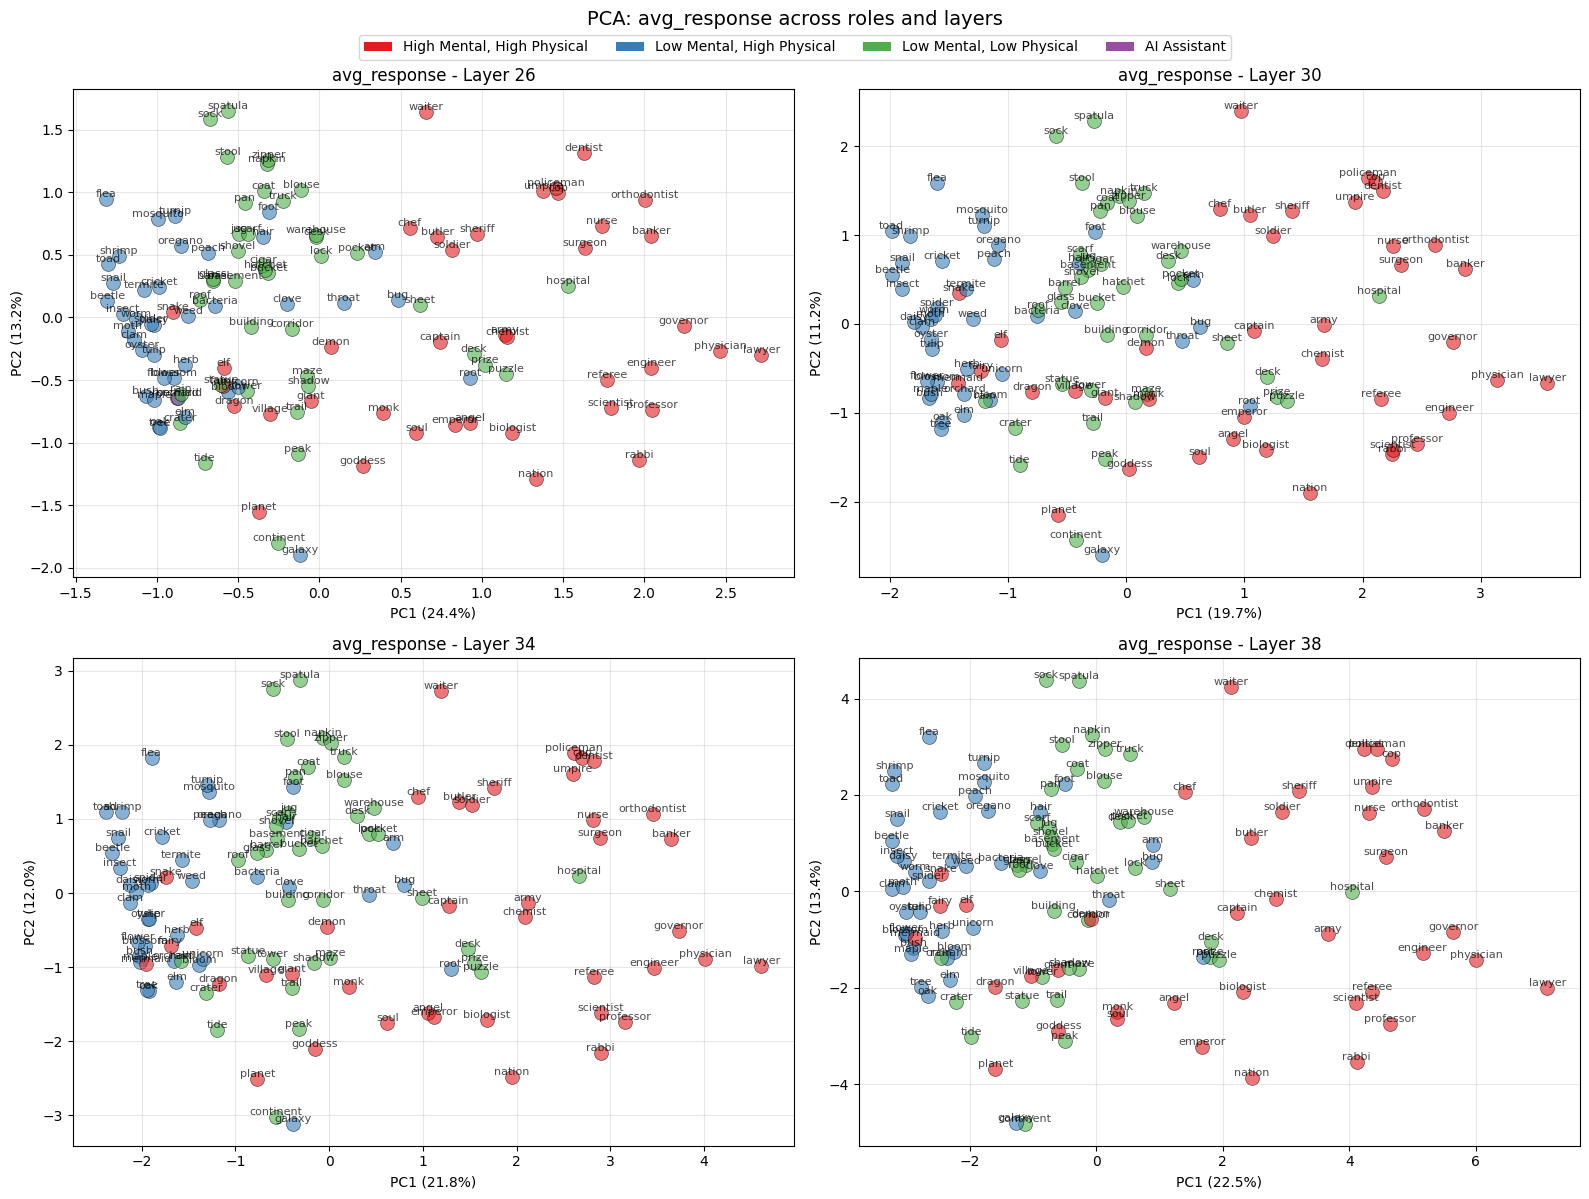

PCA plots created for all activation keys


In [9]:
# Create PCA plots for each activation key across all layers
for key in activation_keys:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, layer in enumerate(layers):
        plot_pca_for_key(key, layer, ax=axes[idx])

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=group_colors[1], label='High Mental, High Physical'),
        Patch(facecolor=group_colors[2], label='Low Mental, High Physical'),
        Patch(facecolor=group_colors[3], label='Low Mental, Low Physical'),
        Patch(facecolor=group_colors[4], label='AI Assistant'),
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=4,
               bbox_to_anchor=(0.5, 0.98), fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f'PCA: {key} across roles and layers', fontsize=14, y=0.995)
    plt.show()

print("PCA plots created for all activation keys")

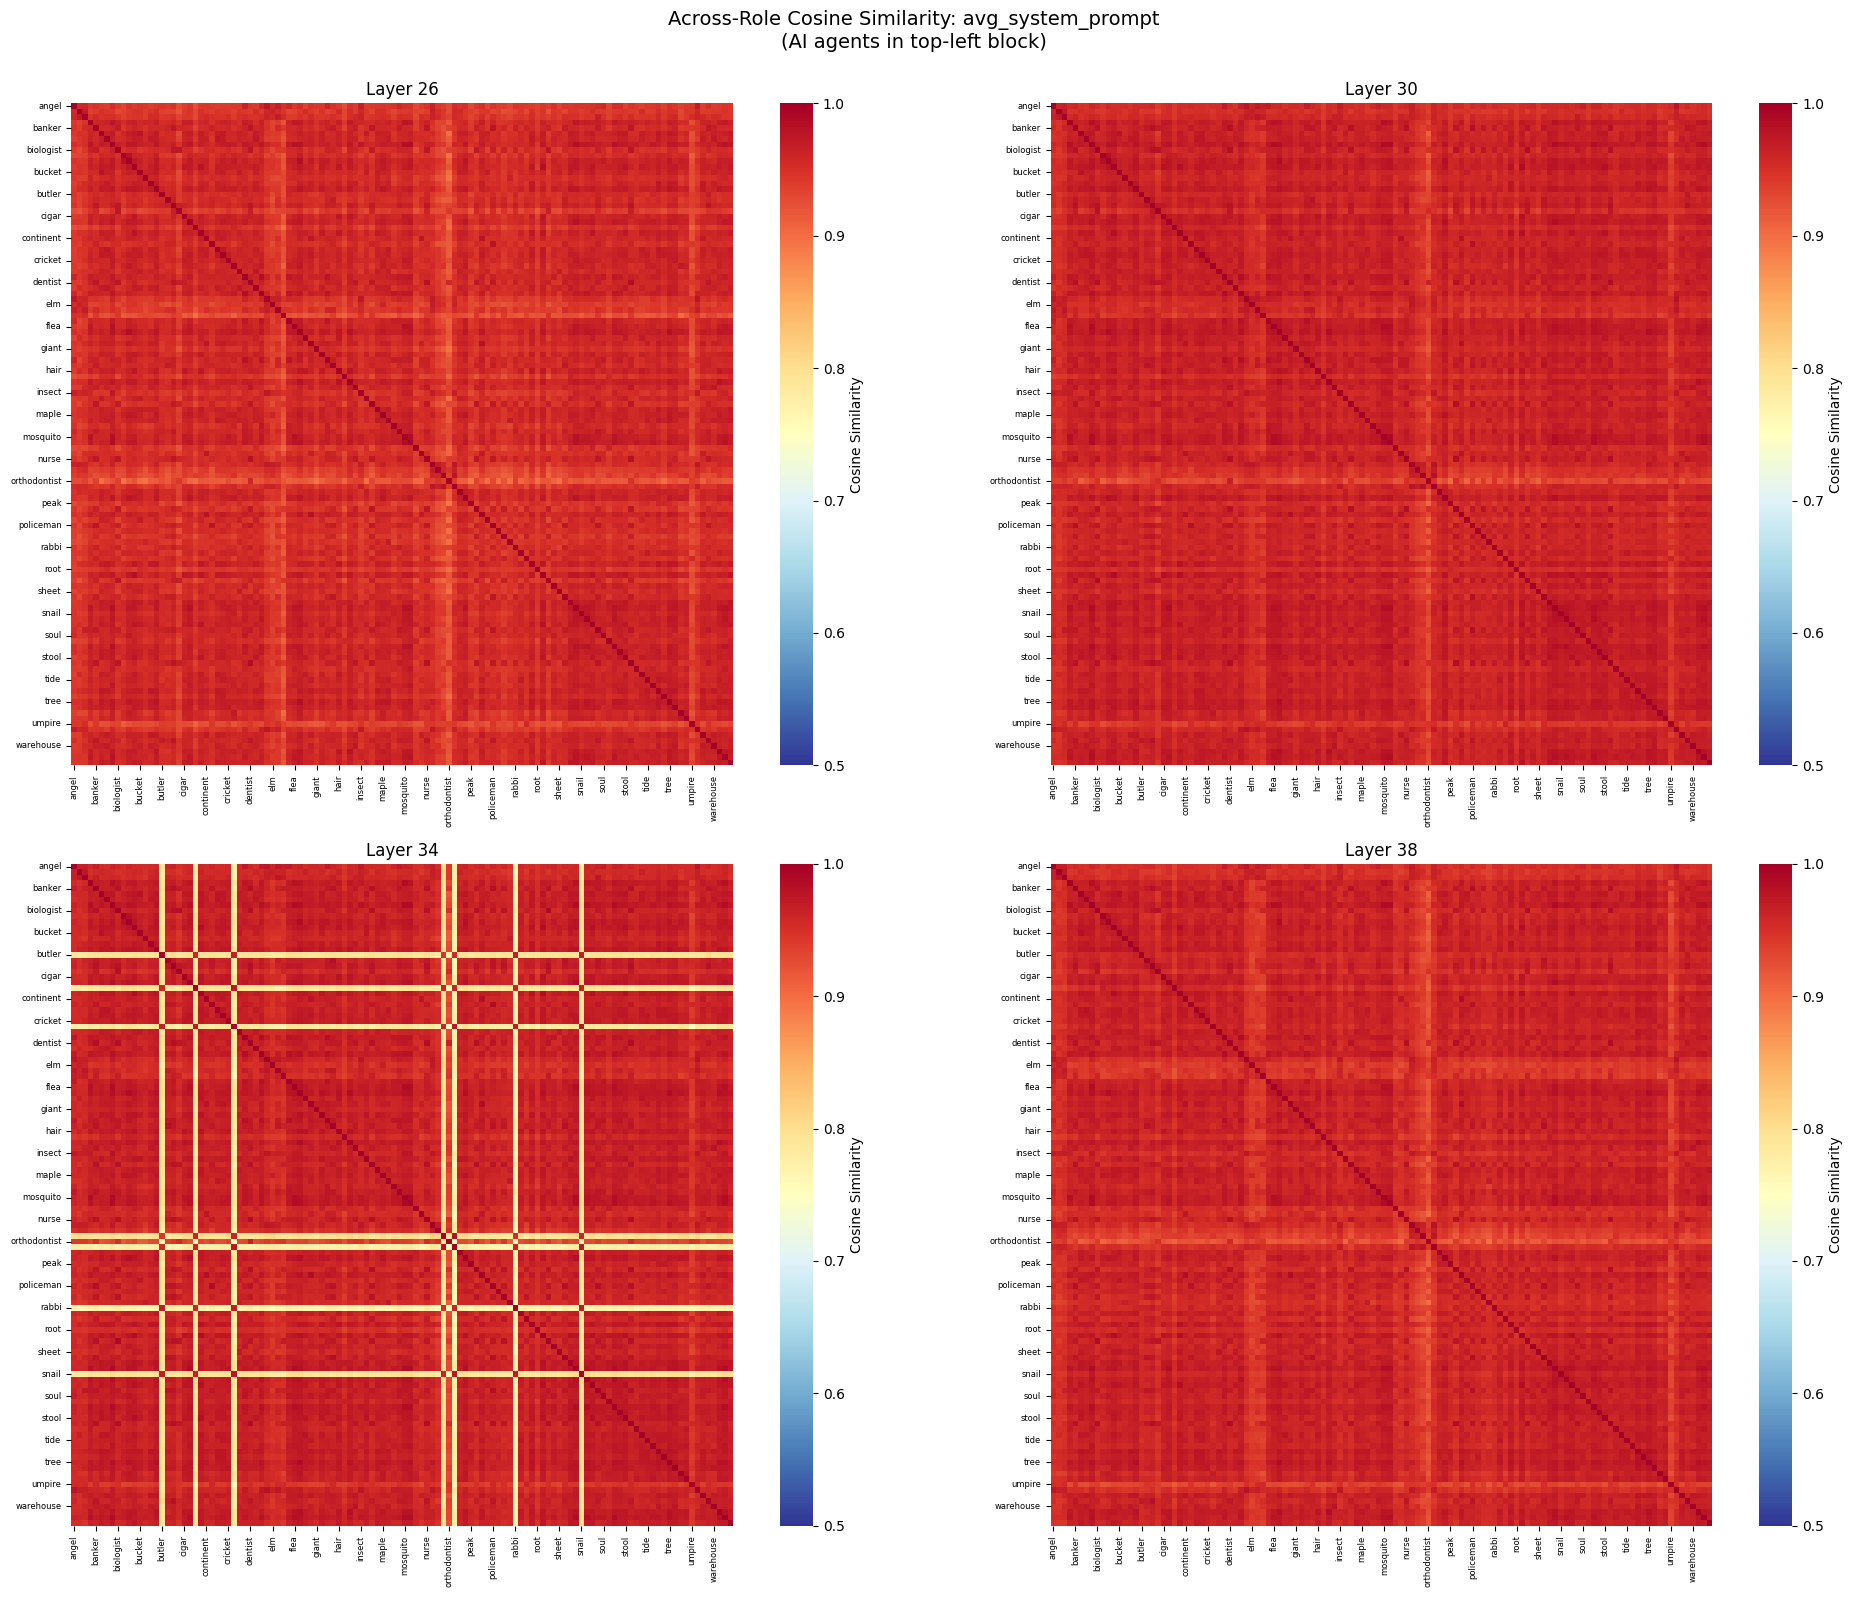

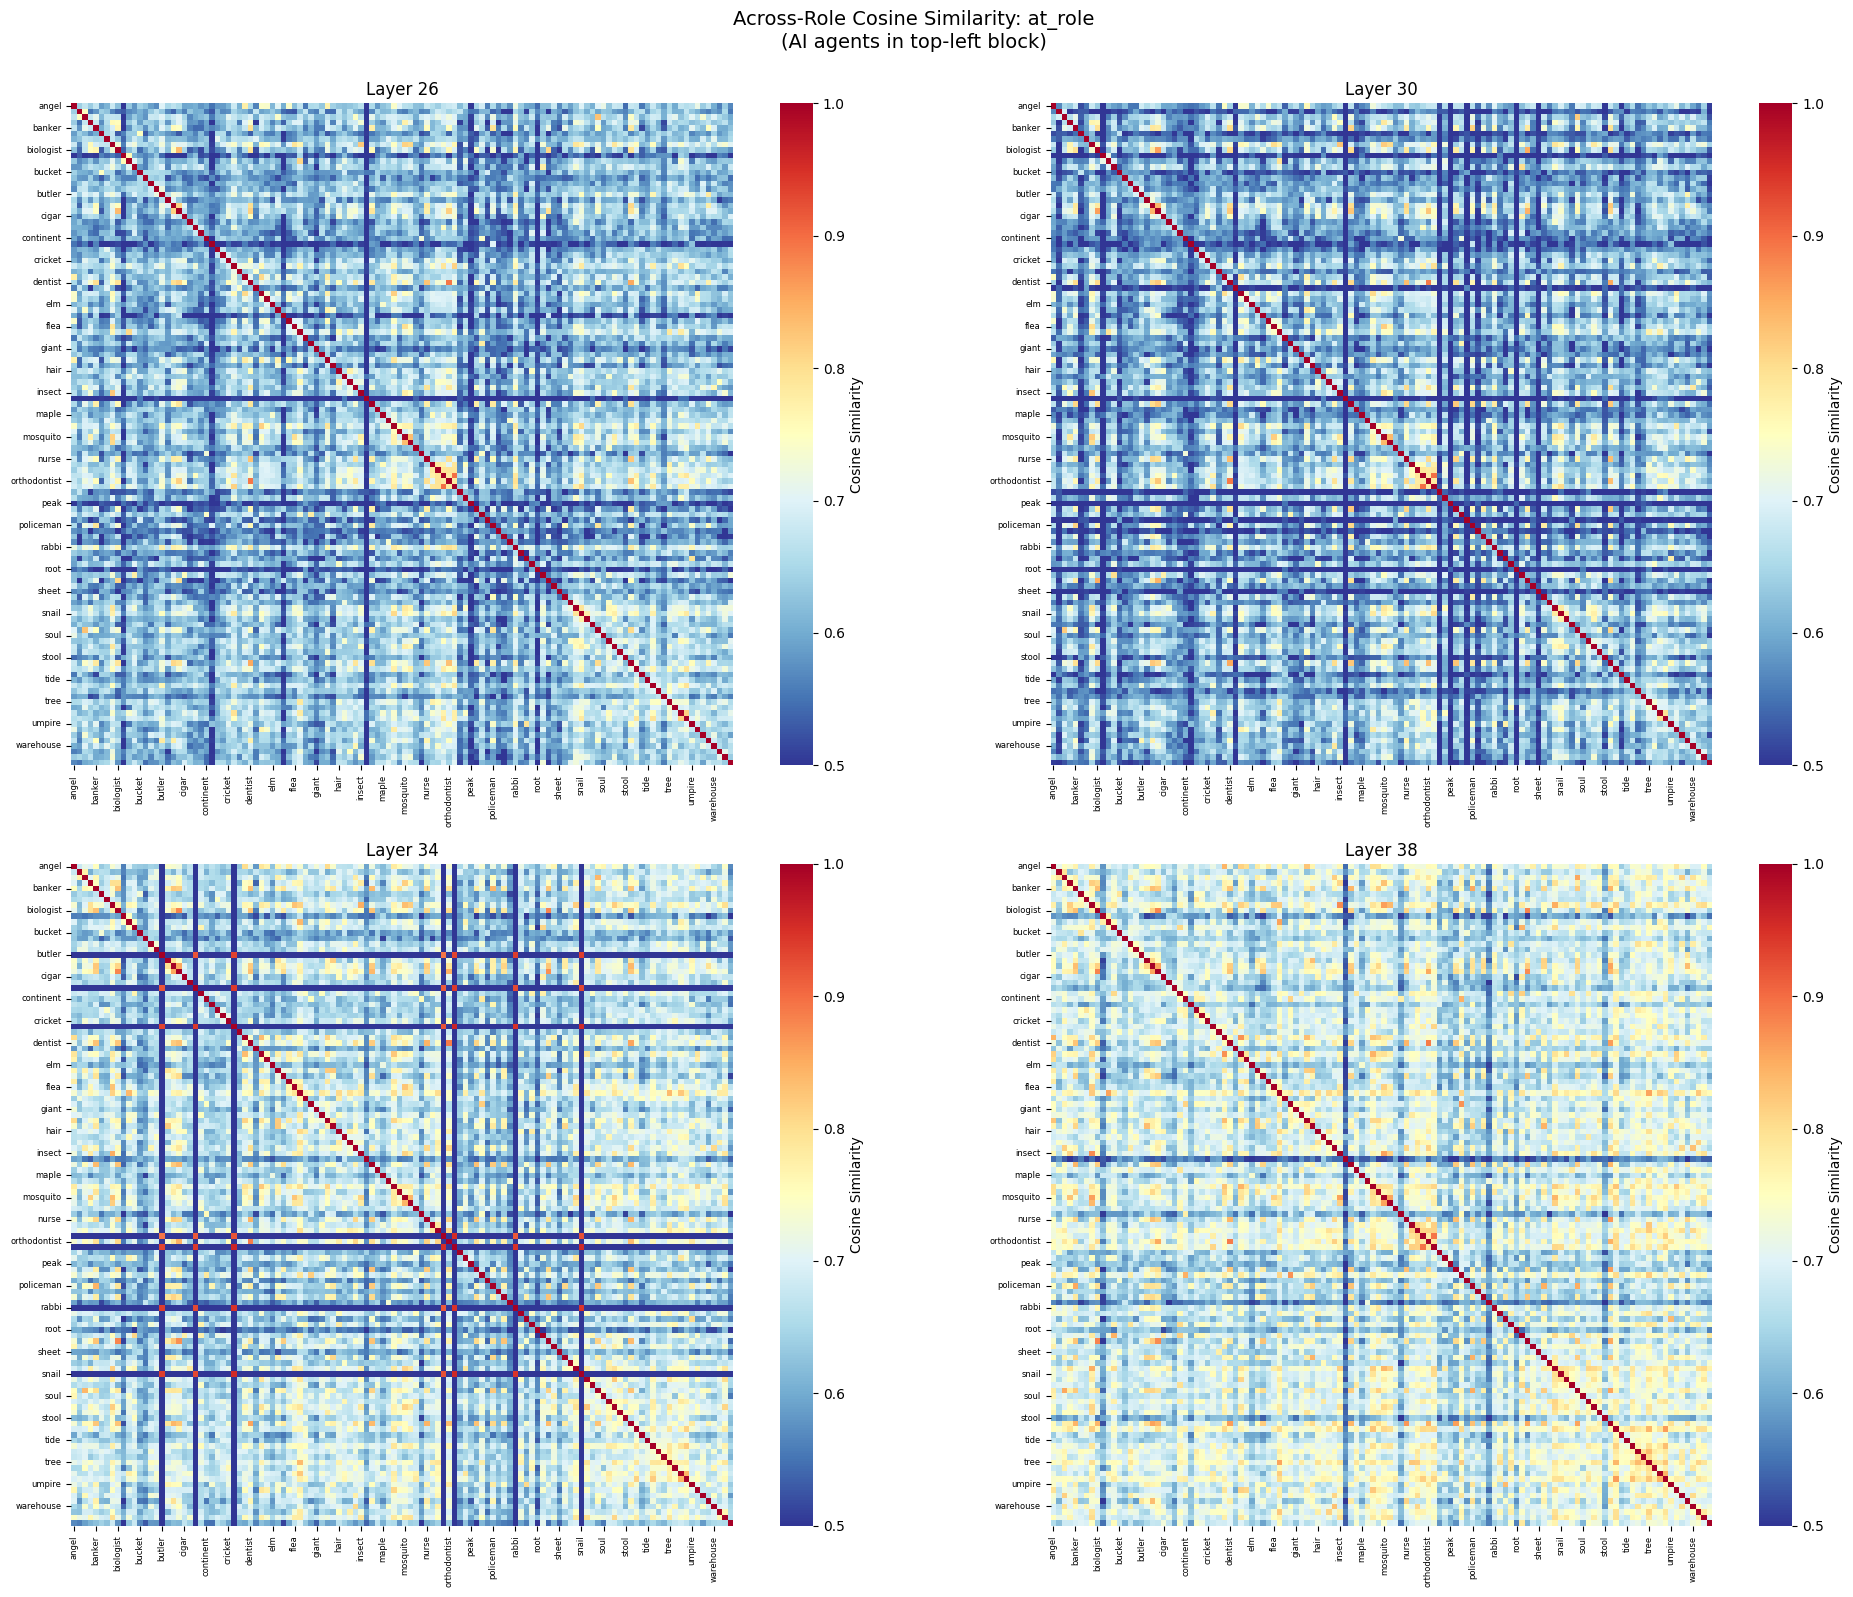

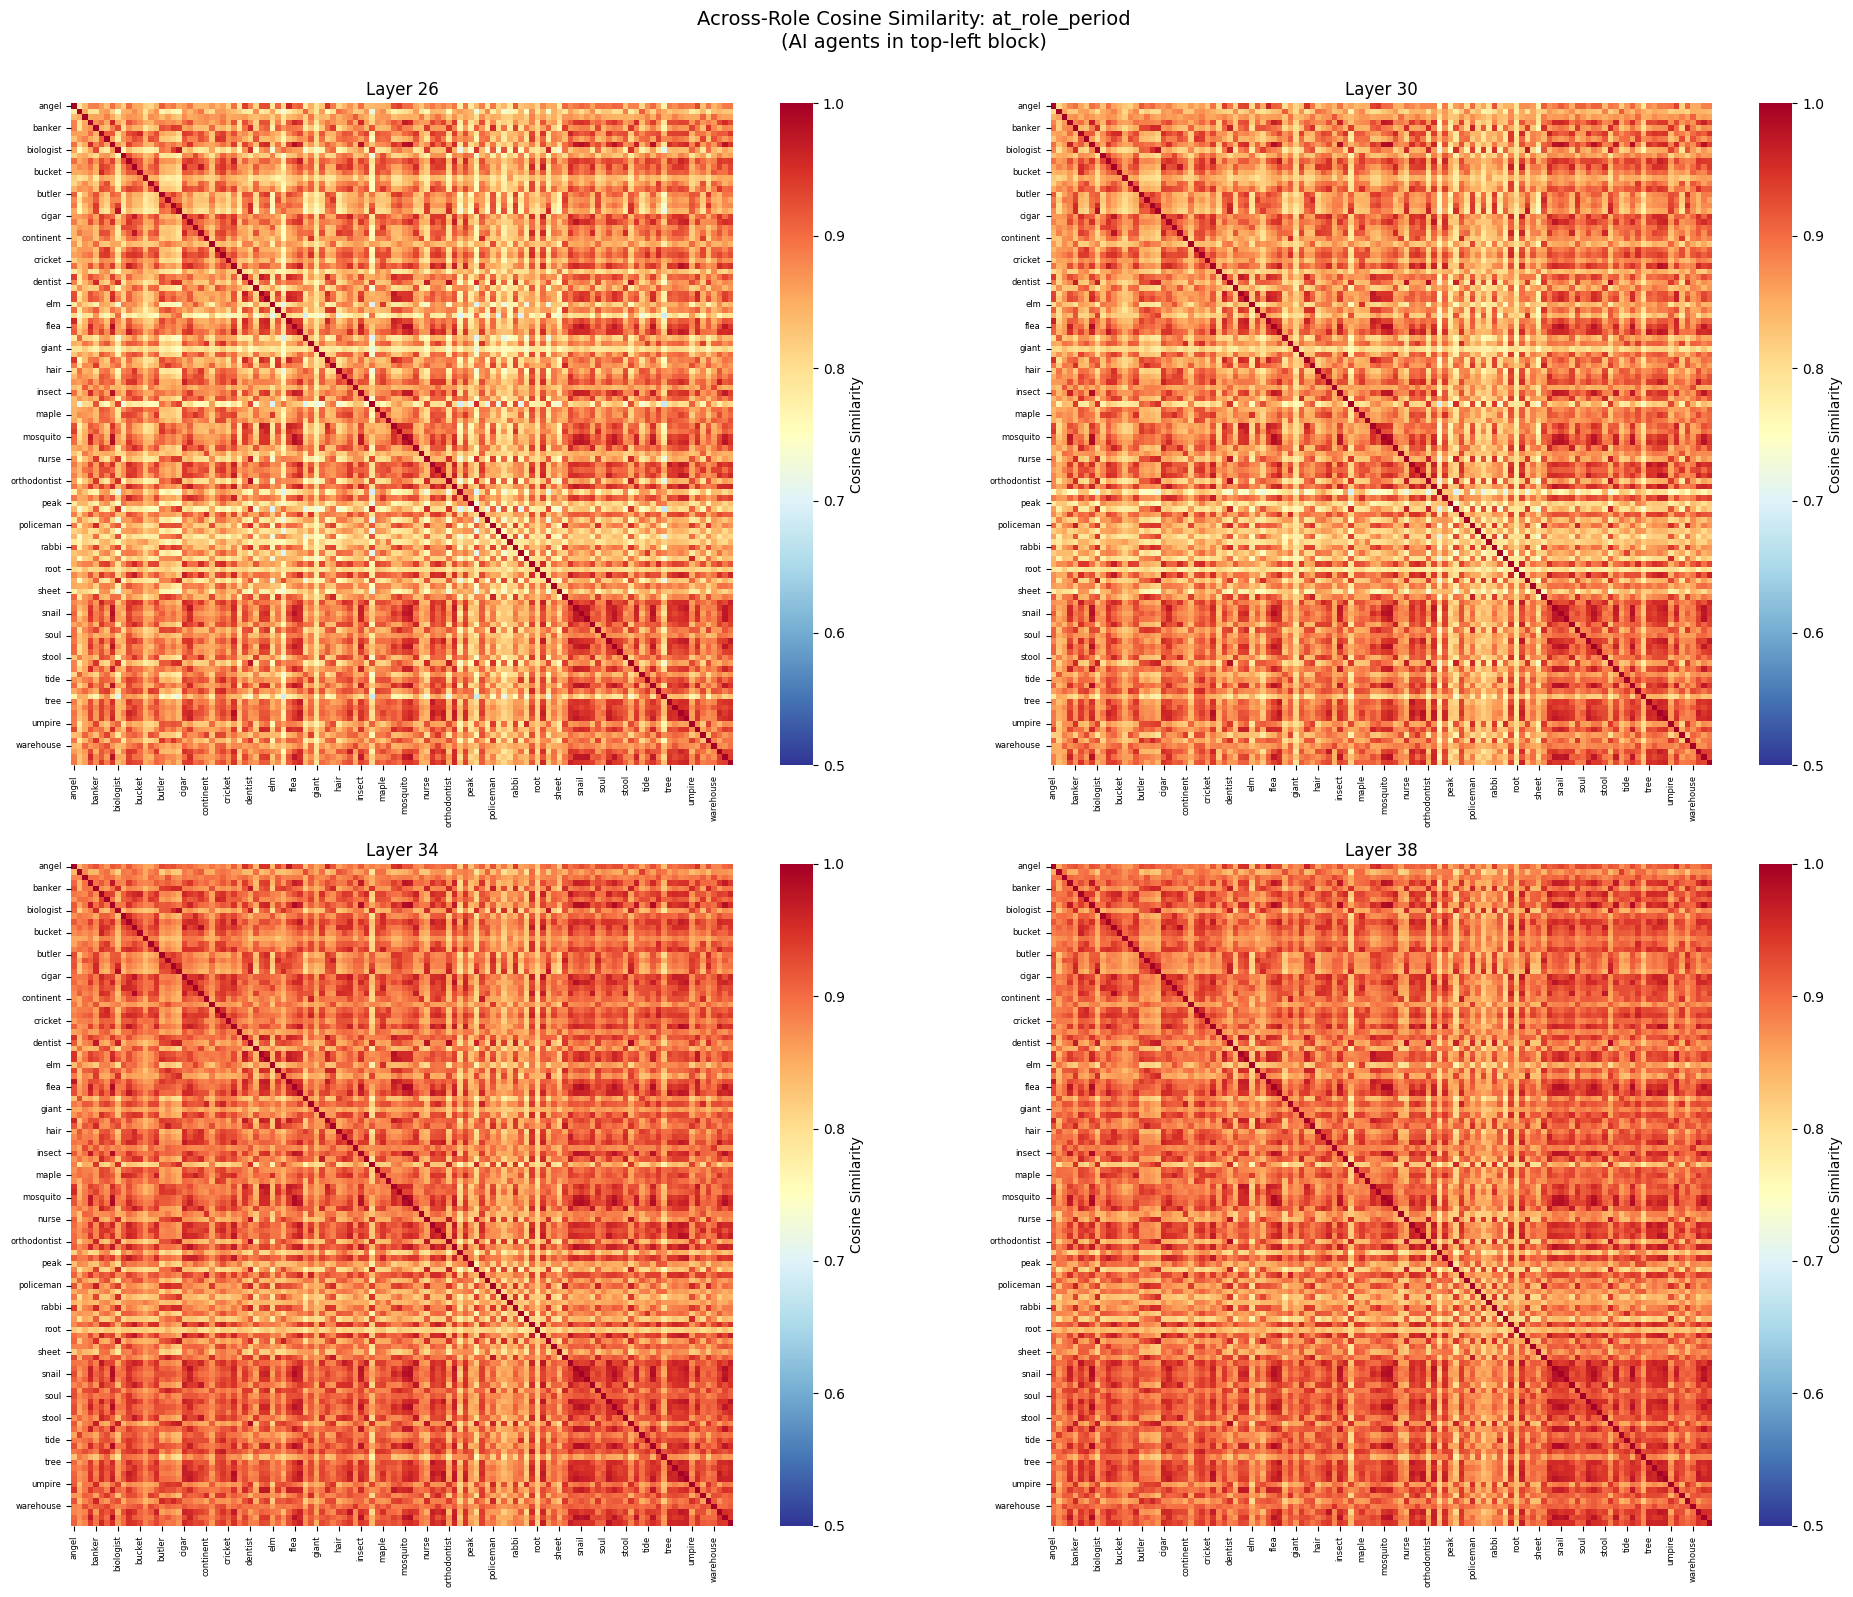

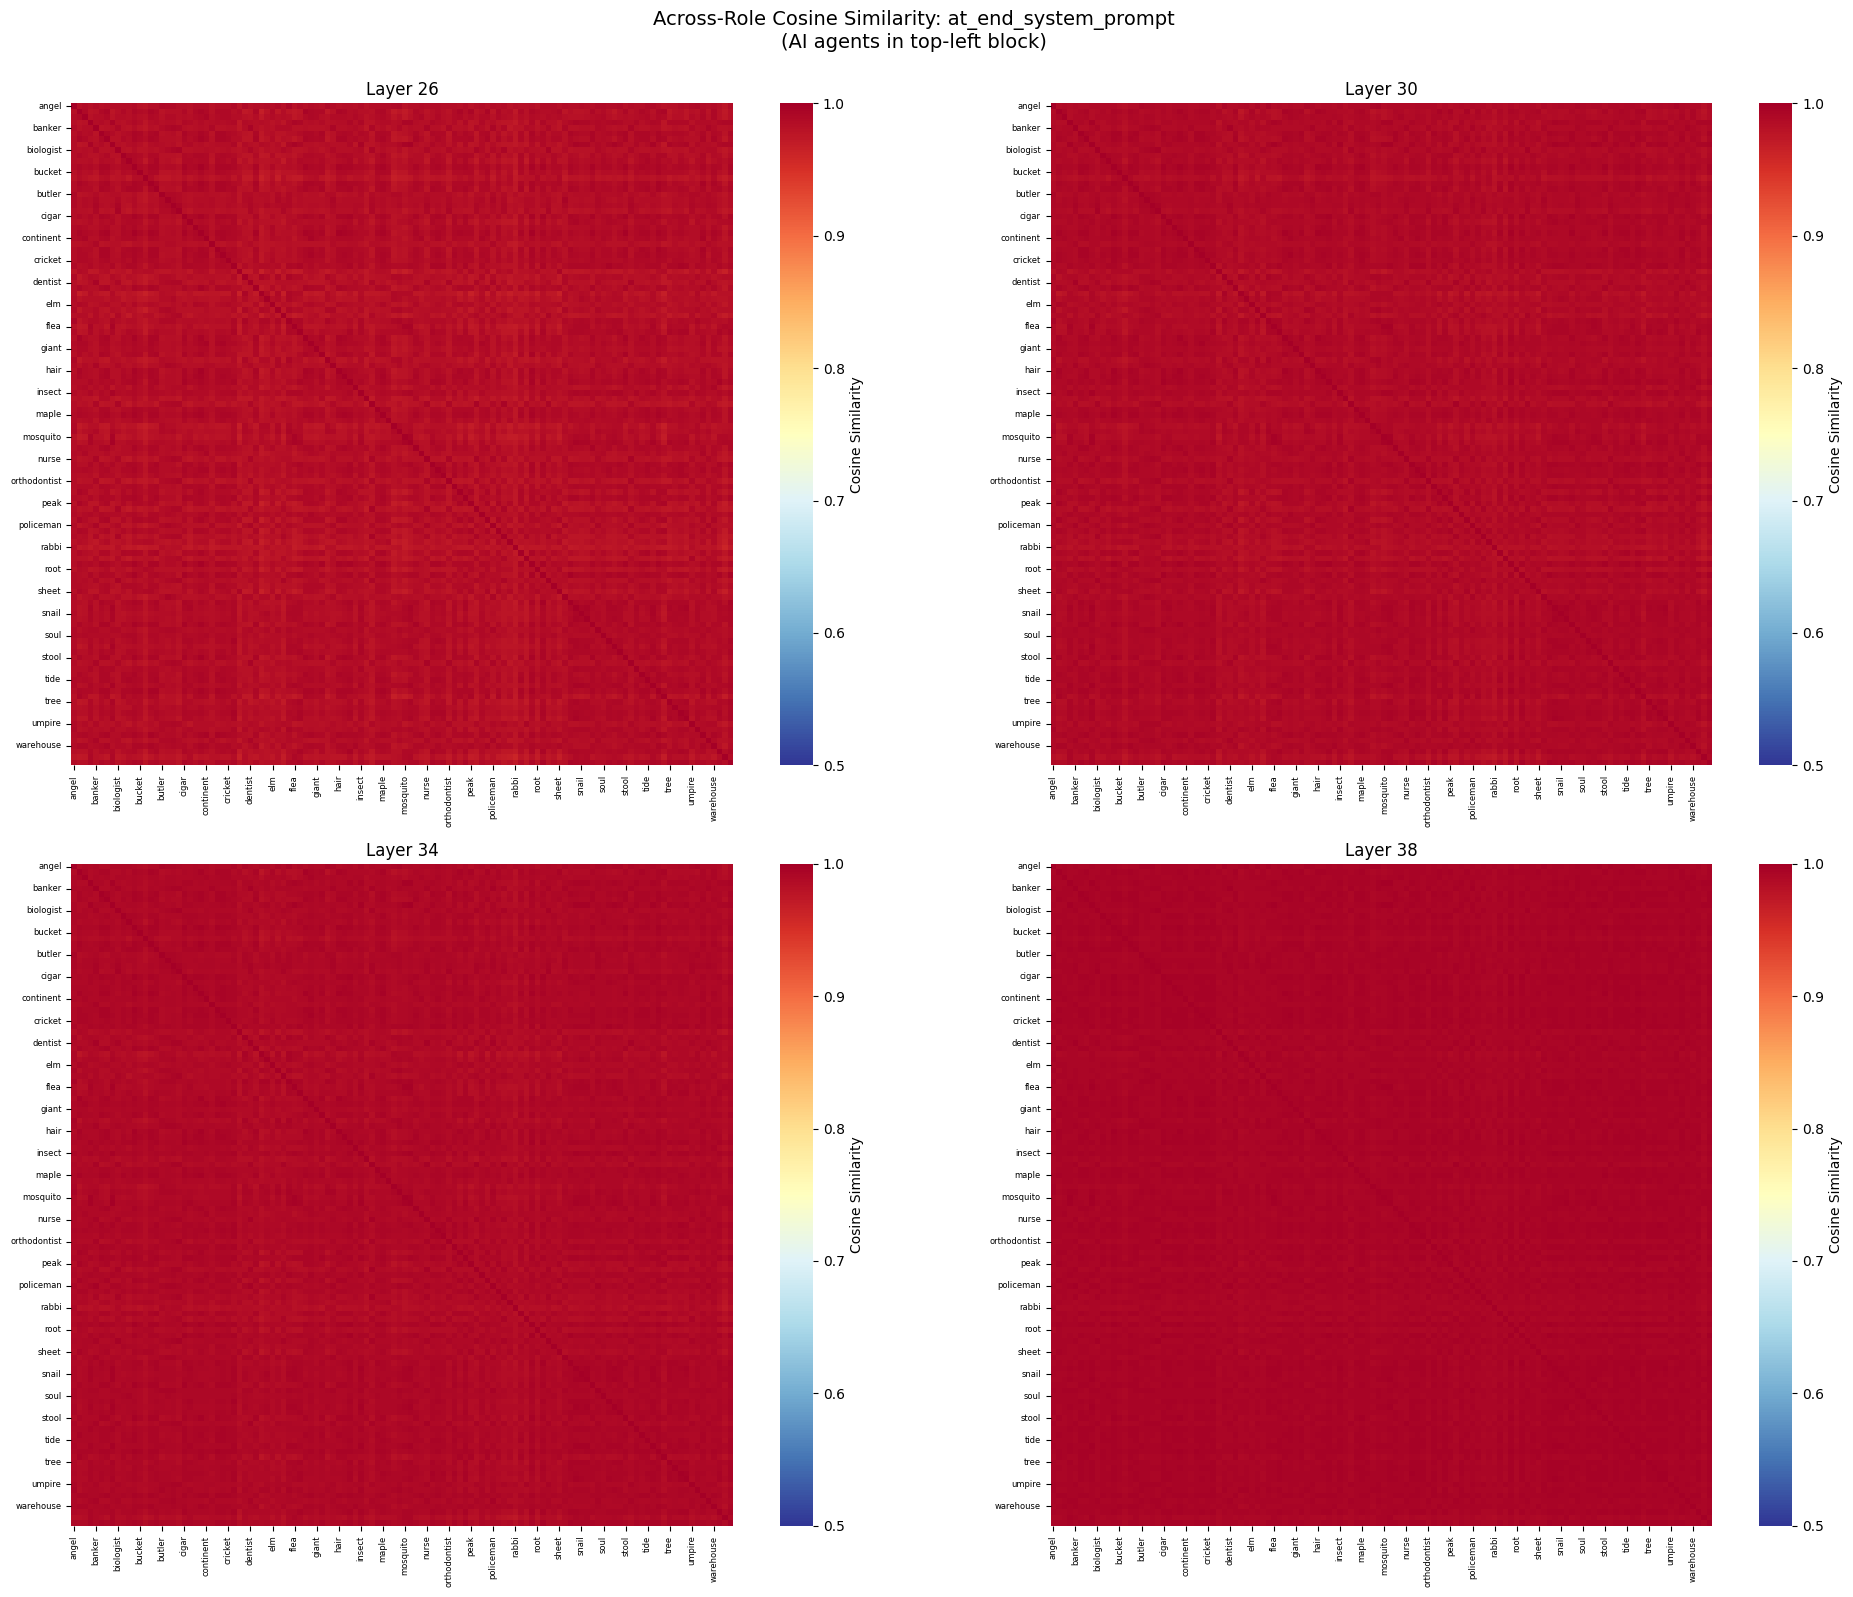

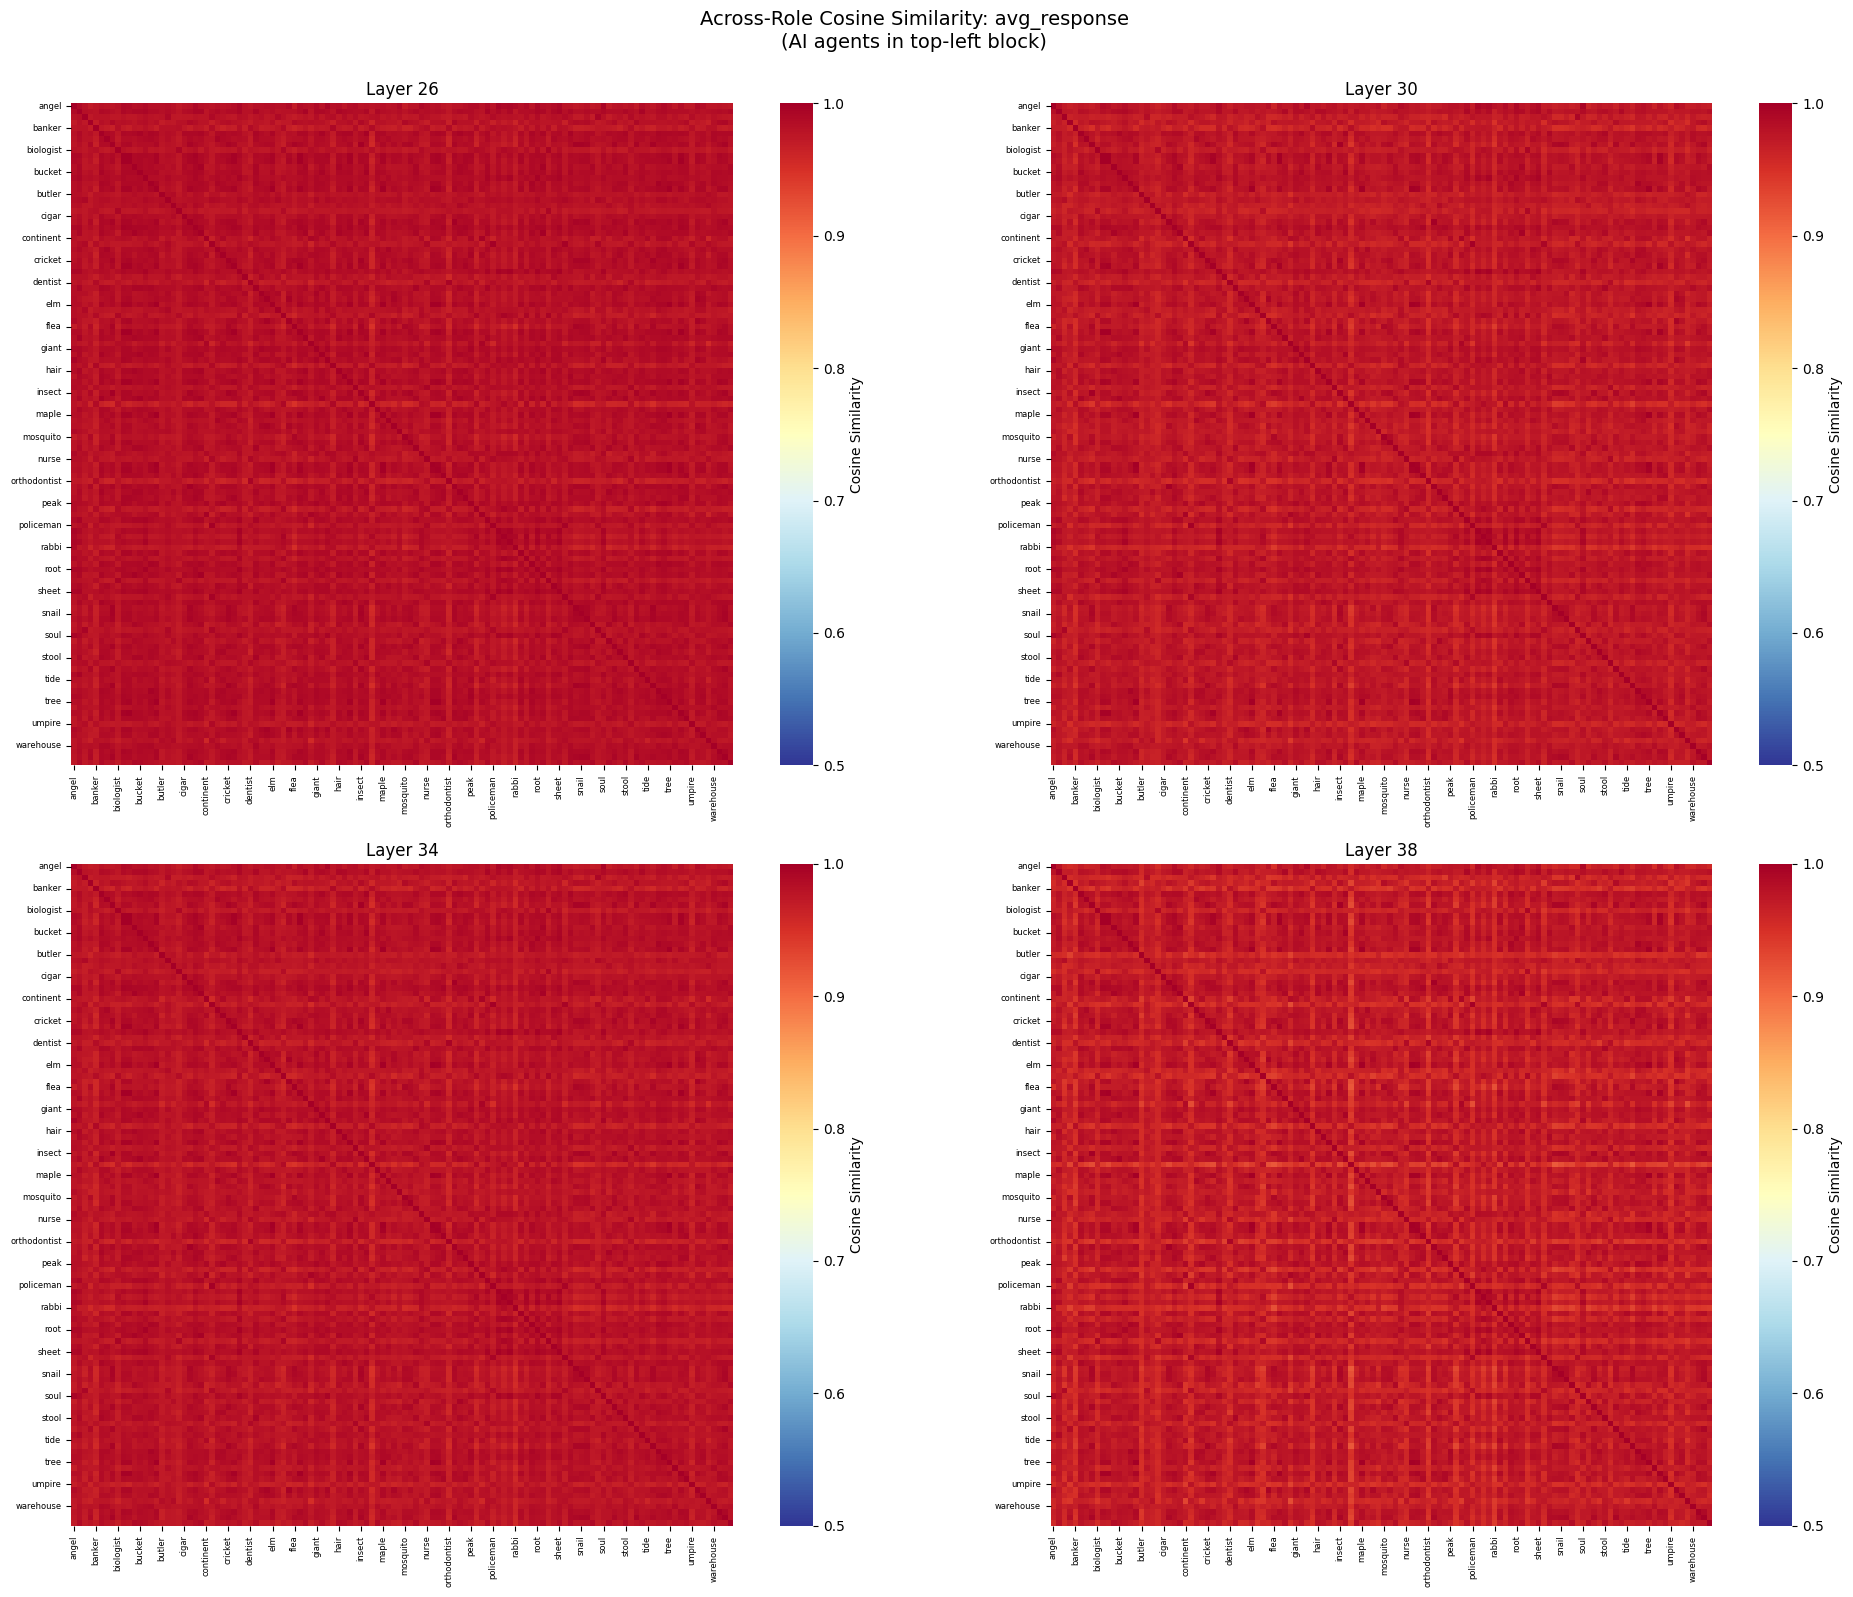

Similarity heatmaps created


In [10]:
# Visualization: Heatmaps of across-role similarities for AI agents
# Show how AI agent roles compare to each other vs other roles

for key in activation_keys:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()

    for idx, layer in enumerate(layers):
        if layer not in across_role_similarities[key]:
            continue

        sim_df = across_role_similarities[key][layer]

        # Reorder rows/columns to group AI agents together
        ai_roles_in_df = [r for r in ai_agent_roles if r in sim_df.index]
        other_roles = [r for r in sim_df.index if r not in ai_agent_roles]
        ordered_roles = ai_roles_in_df + sorted(other_roles)

        sim_df_ordered = sim_df.loc[ordered_roles, ordered_roles]

        # Plot heatmap
        sns.heatmap(sim_df_ordered, ax=axes[idx], cmap='RdYlBu_r',
                   vmin=0.5, vmax=1.0, center=0.75,
                   cbar_kws={'label': 'Cosine Similarity'},
                   square=True)

        # Add dividing lines to separate AI agents
        if len(ai_roles_in_df) > 0:
            axes[idx].axhline(y=len(ai_roles_in_df), color='black', linewidth=2)
            axes[idx].axvline(x=len(ai_roles_in_df), color='black', linewidth=2)

        axes[idx].set_title(f'Layer {layer}', fontsize=12)
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')

        # Rotate labels
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, fontsize=6)
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=0, fontsize=6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f'Across-Role Cosine Similarity: {key}\n(AI agents in top-left block)',
                fontsize=14, y=0.995)
    plt.show()

print("Similarity heatmaps created")

In [11]:
# Summary statistics
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nTotal roles analyzed: {len(role_avg_vectors)}")
print(f"AI agent roles: {ai_agent_roles}")
print(f"Layers analyzed: {layers}")
print(f"Activation keys: {activation_keys}")

# Within-role similarity summary
print("\n" + "="*80)
print("WITHIN-ROLE SIMILARITIES (avg across off-diagonal elements)")
print("="*80)

for role in sorted(within_role_similarities.keys())[:5]:  # Show first 5 roles
    print(f"\n{role}:")
    for layer in layers:
        if layer in within_role_similarities[role]:
            sim_matrix = within_role_similarities[role][layer].values
            mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
            avg_sim = sim_matrix[mask].mean()
            print(f"  Layer {layer}: {avg_sim:.4f}")

# Across-role similarity for AI agents
print("\n" + "="*80)
print("AI AGENT INTER-ROLE SIMILARITIES")
print("="*80)

for key in activation_keys:
    print(f"\n{key}:")
    for layer in layers:
        if layer in ai_agent_similarities[key]:
            sim_matrix = ai_agent_similarities[key][layer].values
            mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
            mean_sim = sim_matrix[mask].mean()
            std_sim = sim_matrix[mask].std()
            print(f"  Layer {layer}: mean={mean_sim:.4f}, std={std_sim:.4f}")

# Compare AI agents vs non-AI agents similarity
print("\n" + "="*80)
print("AI AGENTS vs NON-AI ROLES COMPARISON")
print("="*80)

for key in activation_keys:
    print(f"\n{key}:")
    for layer in layers:
        if layer not in across_role_similarities[key]:
            continue

        sim_df = across_role_similarities[key][layer]
        ai_roles_in_df = [r for r in ai_agent_roles if r in sim_df.index]
        other_roles = [r for r in sim_df.index if r not in ai_agent_roles]

        if len(ai_roles_in_df) > 1 and len(other_roles) > 0:
            # AI-to-AI similarity
            ai_block = sim_df.loc[ai_roles_in_df, ai_roles_in_df].values
            mask = ~np.eye(ai_block.shape[0], dtype=bool)
            ai_to_ai = ai_block[mask].mean()

            # AI-to-others similarity
            ai_to_others = sim_df.loc[ai_roles_in_df, other_roles].values.mean()

            # Others-to-others similarity
            if len(other_roles) > 1:
                others_block = sim_df.loc[other_roles, other_roles].values
                mask_others = ~np.eye(others_block.shape[0], dtype=bool)
                others_to_others = others_block[mask_others].mean()
            else:
                others_to_others = np.nan

            print(f"  Layer {layer}:")
            print(f"    AI↔AI: {ai_to_ai:.4f}")
            print(f"    AI↔Others: {ai_to_others:.4f}")
            print(f"    Others↔Others: {others_to_others:.4f}")
            print(f"    Difference (AI↔AI - AI↔Others): {ai_to_ai - ai_to_others:.4f}")

SUMMARY STATISTICS

Total roles analyzed: 120
AI agent roles: ['AI assistant', 'helpful assistant', 'AI', 'assistant', 'llm']
Layers analyzed: [26, 30, 34, 38]
Activation keys: ['avg_system_prompt', 'at_role', 'at_role_period', 'at_end_system_prompt', 'avg_response']

WITHIN-ROLE SIMILARITIES (avg across off-diagonal elements)

angel:
  Layer 26: 0.6163
  Layer 30: 0.6644
  Layer 34: 0.6624
  Layer 38: 0.6304

arm:
  Layer 26: 0.5987
  Layer 30: 0.6209
  Layer 34: 0.6356
  Layer 38: 0.5961

army:
  Layer 26: 0.6107
  Layer 30: 0.6586
  Layer 34: 0.6508
  Layer 38: 0.6200

bacteria:
  Layer 26: 0.6202
  Layer 30: 0.6760
  Layer 34: 0.6543
  Layer 38: 0.6265

banker:
  Layer 26: 0.6264
  Layer 30: 0.6953
  Layer 34: 0.6689
  Layer 38: 0.6288

AI AGENT INTER-ROLE SIMILARITIES

avg_system_prompt:

at_role:

at_role_period:

at_end_system_prompt:

avg_response:

AI AGENTS vs NON-AI ROLES COMPARISON

avg_system_prompt:

at_role:

at_role_period:

at_end_system_prompt:

avg_response:


In [ ]:
# Save results to files for further analysis
import pickle

output_dir = Path('../analysis/')
output_dir.mkdir(exist_ok=True)

# Save the computed data structures
results = {
    'role_avg_vectors': role_avg_vectors,
    'within_role_similarities': within_role_similarities,
    'across_role_similarities': across_role_similarities,
    'ai_agent_similarities': ai_agent_similarities,
    'ai_agent_roles': ai_agent_roles,
    'layers': layers,
    'activation_keys': activation_keys,
}

with open(output_dir / 'activation_analysis_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {output_dir / 'activation_analysis_results.pkl'}")

# Also save summary statistics to CSV
summary_rows = []

for key in activation_keys:
    for layer in layers:
        if layer not in across_role_similarities[key]:
            continue

        sim_df = across_role_similarities[key][layer]
        ai_roles_in_df = [r for r in ai_agent_roles if r in sim_df.index]
        other_roles = [r for r in sim_df.index if r not in ai_agent_roles]

        if len(ai_roles_in_df) > 1 and len(other_roles) > 0:
            # AI-to-AI similarity
            ai_block = sim_df.loc[ai_roles_in_df, ai_roles_in_df].values
            mask = ~np.eye(ai_block.shape[0], dtype=bool)
            ai_to_ai = ai_block[mask].mean()

            # AI-to-others similarity
            ai_to_others = sim_df.loc[ai_roles_in_df, other_roles].values.mean()

            # Others-to-others similarity
            if len(other_roles) > 1:
                others_block = sim_df.loc[other_roles, other_roles].values
                mask_others = ~np.eye(others_block.shape[0], dtype=bool)
                others_to_others = others_block[mask_others].mean()
            else:
                others_to_others = np.nan

            summary_rows.append({
                'activation_key': key,
                'layer': layer,
                'ai_to_ai_similarity': ai_to_ai,
                'ai_to_others_similarity': ai_to_others,
                'others_to_others_similarity': others_to_others,
                'difference_ai_vs_others': ai_to_ai - ai_to_others,
            })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(output_dir / 'similarity_summary.csv', index=False)
print(f"Summary statistics saved to {output_dir / 'similarity_summary.csv'}")
print("\nSummary preview:")
print(summary_df)